In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("Data_Washington Fatal Crash Survey.csv", low_memory=False)
zips = pd.read_csv("US%20Zip%20Codes%20from%202013%20Government%20Data.txt")

In [9]:
from arcgis.geocoding import reverse_geocode
from arcgis.geometry import Geometry
from arcgis.gis import GIS

## Derive zip code for crashes 

Method: Reverse geocoding with ArcGIS and impute any missing zipcode values

In [10]:
# long : x
# lat : y

# driver zip code : dzip 
df.rename(columns={'x': 'lon', 'y': 'lat'}, inplace=True)

In [12]:
gis = GIS(api_key="AAPK206d8c337d5a416ca8a7824330c0ca7bkQWmIxSD8K5_qxX1ly5btaWLcl36cVX_1iDwCQxl_IgY56Zh6TN-Usx26i4oM77l")
# exposed for now

def get_zip(df,lon_field, lat_field):
    location = reverse_geocode((Geometry({"x":float(df[lon_field]),"y":float(df[lat_field]), "spatialReference":{"wkid":4326}})))
    return location['address']['Postal']

df['crashzip'] = df.apply(get_zip, axis=1, lat_field='lat', lon_field='lon')

In [83]:
# update missing crash zip values in df 
# case 78 03/18/2020 in county 45(Pacific) --> crash lat long improperly recorded  78.304936,  -778.304936 impossible! city = unincorporated
# FOREST SERVICES RD 2300 is not an actual road... should we drop the row?
# case 349 09/12/2021 in county 5 --> zip: 99352 could not be identified by arcGIS identified using haversine distance
# case 638 09/05/2021 in county 19(Ferry) --> lat long recorded as 78.304936,  -778.304936 impossible! city = unincorporated
# Ferry county is on a reservation in the middle of nowhere next to a natl forest far northeast of WA 
# crash occurred on BRIDGE CREEK RD in Ferry County --> brute force zip: 99138

df.loc[3690,"crashzip"] = 99352
df.loc[4128,"crashzip"] = 99138

In [84]:
# saved because computationally expensive 
# don't want to call API every time we run the code 
# DONT RUN THAT PART 

df.to_csv('crashdata_updated.csv') # import THIS data set

## What proportion of drivers are involved in fatal crashes crash in communities where they live?

Method: Calculate proportion mathematically

In [1172]:
# start from here
# processed in "preprocessing" notebook

data = pd.read_csv("crashdata_updated.csv", low_memory=False) # some cols have mixed dtypes...
data["crash_dt"]= pd.to_datetime(data["crash_dt"])

# cast as str 
data['dzip'] = data['dzip'].astype(str)
# get rid of the trailing zeros
data['dzip'] = data['dzip'].replace(r'\.0$', '', regex=True)

## Recalculate proportions-- this time community = CITY

In [1175]:
print("The proportion of drivers involved in fatal crashes in communities where they don't live = {}".format(len(data.query('dcity != crashcity'))/len(data)))
print("The proportion of drivers involved in fatal crashes in communities where they live = {}".format(len(data.query('dcity == crashcity'))/len(data)))

The proportion of drivers involved in fatal crashes in communities where they don't live = 0.6330935251798561
The proportion of drivers involved in fatal crashes in communities where they live = 0.3669064748201439


In [1176]:
print(data.groupby(data.crash_dt.dt.year)['dcity'].value_counts())

crash_dt  dcity      
2017      Seattle        53
          Spokane        37
          Tacoma         28
          Vancouver      22
          Yakima         19
                         ..
2021      Wishram         1
          Woodinville     1
          Woodland        1
          Woodway         1
          Yuba City       1
Name: dcity, Length: 1205, dtype: int64


- Calculate the same proportions for before Spring 2020 and after Spring 2020
- Represent these 3 proportions in a horizontal stacked bar chart 

In [ ]:
## Recalculating proportions of crashes with visitors vs. residents for pre and post-pandemic
- Calculate the same proportions for before Spring 2020 and after Spring 2020
-Represent these 3 proportions in a horizontal stacked bar chart

In [ ]:
# Add another column to dataset indicating if it is pre or post covid (covid is in post-covid)
# Post-Covid is defined as March 1 2020, as the Governor of Washington declared a state of emergency on Feb 29, 2020

covid = [] # set empty list 
startdate = pd.to_datetime("2020-3-1").date()

for index, row in data.iterrows():
    if row['crash_dt']<startdate:
        covid.append("pre-pandemic") # if equal add "resident" to list
    else:
        covid.append("post-pandemic") # else add "visitor"
        
data["covid"] = covid # cast list as df column

In [ ]:
# Pre-pandemic
print("Pre-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they don't live = %1.4f" % (len(data[data['covid'] == "pre-pandemic"].query('dcity != crashcity'))/len(data[data['covid'] == "pre-pandemic"])))
print("Pre-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they live = %1.4f" % (len(data[data['covid'] == "pre-pandemic"].query('dcity == crashcity'))/len(data[data['covid'] == "pre-pandemic"])))

# Post-pandemic
print("Post-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they don't live = %1.4f" % (len(data[data['covid'] == "post-pandemic"].query('dcity != crashcity'))/len(data[data['covid'] == "post-pandemic"])))
print("Post-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they live = %1.4f" % (len(data[data['covid'] == "post-pandemic"].query('dcity == crashcity'))/len(data[data['covid'] == "post-pandemic"])))

## Is there a difference between types of crashes and behavior factors among residents vs visitors?

Method: Chi-Squared Test for Homogeneity between crashes among residents and visitors


In [1177]:
# Create a categorical variable to represent whether driver is local resident or visitor
# "resident" = local resident
# "visitor" = out of town

drive_res = [] # set empty list 
for index, row in data.iterrows():
    if row['dzip']==row['crashzip']:
        drive_res.append("resident") # if equal add "resident" to list
    else:
        drive_res.append("visitor") # else add "visitor"
        
data["d_res"] = drive_res # cast list as df column

In [1178]:
# Create a categorical variable to represent whether driver is local resident or visitor
# "resident" = local resident
# "visitor" = out of town

### BASED ON CITY MATCH

city_res = [] # set empty list 
for index, row in data.iterrows():
    if row['dcity']==row['crashcity']:
        city_res.append("resident") # if equal add "resident" to list
    else:
        city_res.append("visitor") # else add "visitor"
        
data["d_cty"] = city_res # cast list as df column

# "d_cty" : classifies driver as resident or visitor by CITY 
# "d_res" : classifies driver as resident or visitor by ZIP

In [1179]:
from scipy.stats import chi2_contingency

chi1 = chi2_contingency(pd.crosstab([data.year], data.d_cty, rownames=["Year"], colnames=["Driver"], margins=True, margins_name="Total"))
print("The p-value is ={}".format(chi1.pvalue))
print("The year by year distribution of visitors vs residents involved in fatal crashes does not change significantly.")

The p-value is =0.5923499100705489
The year by year distribution of visitors vs residents involved in fatal crashes does not change significantly.


In [1180]:
colist = ["numfatal", "agegrp2", "trafflow", "roadclass", "urbrur", "intersect","lanedep", "oppdir", "wrongway","pv_inv","ped_inv","ht_inv","bike_inv", "mc_inv","dd_inv", "speed_inv","drowsy_inv", "drdist_inv","aid_inv","id_inv","mj_inv","fty_inv","dr_drink","dr_alc8","dr_alc7","dr_spd"]
values = []

for k in colist:
    pval=chi2_contingency(pd.crosstab(data[k],data["d_cty"], margins=True, margins_name="Total")).pvalue
    values.append(pval)
    
sig = dict(zip(colist, values))
print("All p-values:")
print(sig)
print("Signficant p-values:")
print({k:v for k, v in sig.items() if v < 0.05})

All p-values:
{'numfatal': 0.8817144300749307, 'agegrp2': 0.1160865472995747, 'trafflow': 2.7460967027925285e-18, 'roadclass': 4.09273701459027e-68, 'urbrur': 1.1427260420303382e-23, 'intersect': 1.2485938320723234e-09, 'lanedep': 0.00030316221944040286, 'oppdir': 0.00011065378615566232, 'wrongway': 0.007089365597776291, 'pv_inv': 0.005082584937617593, 'ped_inv': 0.0007305364989739545, 'ht_inv': 5.765121486991463e-19, 'bike_inv': 0.04146370660378593, 'mc_inv': 0.8533632086222931, 'dd_inv': 0.9898969600211072, 'speed_inv': 0.9920431928129856, 'drowsy_inv': 0.9999389138843816, 'drdist_inv': 0.9999626201861774, 'aid_inv': 0.9973993959431445, 'id_inv': 0.764343110590218, 'mj_inv': 0.8042887554573764, 'fty_inv': 0.0001585434839524297, 'dr_drink': 0.6272074595324417, 'dr_alc8': 0.8844727191708381, 'dr_alc7': 0.9999703807316164, 'dr_spd': 0.6373865200585607}
Signficant p-values:
{'trafflow': 2.7460967027925285e-18, 'roadclass': 4.09273701459027e-68, 'urbrur': 1.1427260420303382e-23, 'intersec

## Are there specific resident ZIP Codes that tend to produce higher-risk drivers that are involved in fatal crashes at a higher rate?

- We define the rate at which zip codes tend to produce higher risk drivers as the sum of drivers from each zip code divided by the 5 year span to get the average number of high risk drivers produced by a zip code per year

In [380]:
# note: we know there are 28 fatal crashes caused by drivers from CANADA

In [1181]:
# rate of drivers causing fatal crashes per zipcode per year
riskrate = pd.DataFrame(data['dzip'].value_counts()/5).head(17) # 17 instead of 15 because 15,16,17 are equal

In [1182]:
risky = pd.DataFrame(data.groupby(data.crash_dt.dt.year)['dzip'].value_counts())
risky.rename(columns={'dzip':'counts'},inplace=True)

In [1183]:
top17 = list(riskrate.index)
risky.reset_index(inplace=True)
# get data with just top 15 highest risk zip codes

highrisk = risky[risky['dzip'].isin(top17)]
print("The top 17 zip codes that produce high risk drivers are: {}".format(top17))
# 0 is canada

The top 17 zip codes that produce high risk drivers are: ['99301', '98444', '98387', '98837', '98404', '98391', '98951', '98003', '98901', '98223', '98258', '99206', '98584', '98022', '0', '98902', '98168']


In [1184]:
riskrate.reset_index(inplace=True)

In [1187]:
risky['Risk']=risky['dzip'].isin(top17).astype(int)

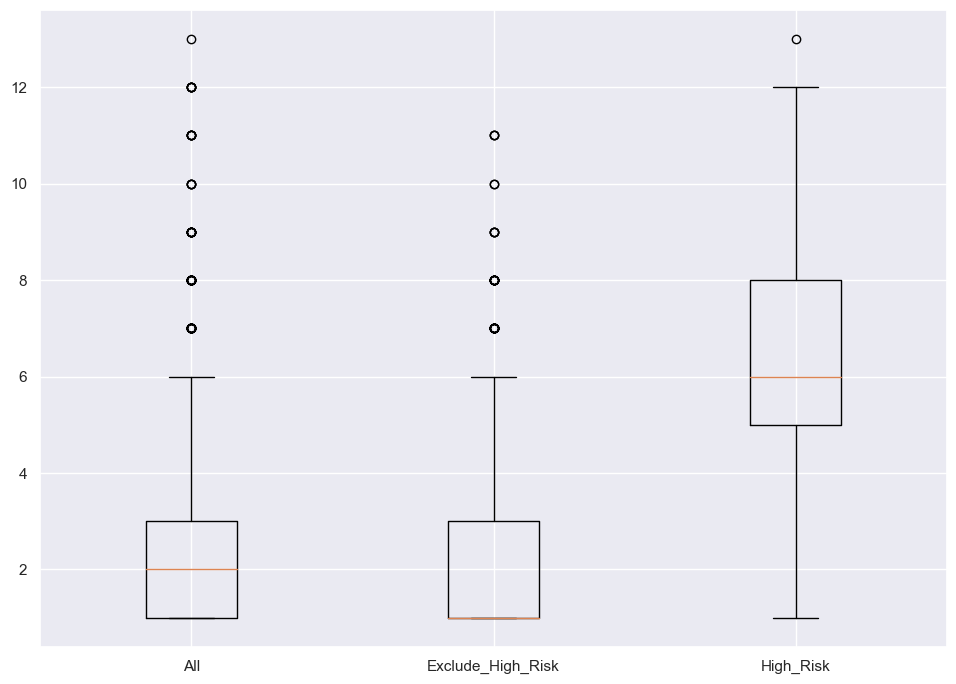

In [1188]:
plt.boxplot([risky['counts'], risky[risky['Risk'] == 0]['counts'] , risky[risky['Risk'] == 1]['counts']], labels=['All','Exclude_High_Risk','High_Risk'])
plt.show(box)

In [1190]:
# change name of 'index' to avoid errors 

riskrate.rename(columns={'index':'zipcode', 'dzip':'rate'}, inplace=True)

In [1192]:
riskrate.to_csv("riskrate.csv")

## What are the population demographics of these high-risk driver producing ZIP Codes?

The top 17 highest risk zip codes belong to 8 counties in WA state, excluding Canada. 

To analyze the demographics of high-risk producing zip codes, we examine the demographics of the county to which it belongs. We also examine how many people in each of the counties belong to high-risk zip codes. 

In [1198]:
# riskrate with added population demographics

# the population demographics are COUNTY level
# percent_pop : the percentage of the COUNTY's population that belong to the ZIP
# working_perc : the percentage of working age population by COUNTY

riskrate = pd.read_csv("riskrate.csv")

In [1203]:
targetzips = ['99301', '98444', '98387', '98837', '98404', '98391', '98951',
       '98003', '98901', '98223', '98258', '99206', '98584', '98022', '0',
       '98902', '98168']

# this is data where the driver belongs to high risk zip code 

newdata = data.loc[data['dzip'].isin(targetzips)]

In [1210]:
# working population data of not high risk

demo_nhr = pd.read_csv("nhr_workingpop.csv")

In [1219]:
print("The median working age percentage of the population for WA counties excluding high-risk = {}".format(demo_nhr['working_perc'].median()))
print("The median working age percentage of the population for WA counties with high-risk zips = {}".format(riskrate['working_perc'].median()))

The median working age percentage of the population for WA counties excluding high-risk = 0.5978580520563578
The median working age percentage of the population for WA counties with high-risk zips = 0.6628895092043154


In [1200]:
# read in median income data 

income = pd.read_csv("med_income_washco.csv")

In [859]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ['White', 'Black or African American', ' American Indian and Alaska Native','Asian',' Native Hawaiian and Other Pacific Islander', 'Hispanic', 'Two or More Races']

specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}],[{'type':'domain'}, {'type':'domain'}],[{'type':'domain'}, {'type':'domain'}]]
pies = make_subplots(rows=4, cols=2, specs=specs, subplot_titles=['Franklin', 'Grant', 'King', 'Mason', 'Pierce', 'Snohomish', 'Spokane', 'Yakima'])

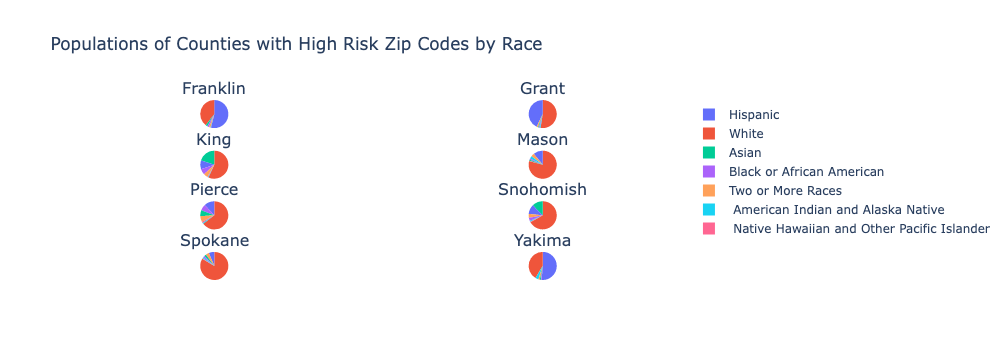

In [860]:
pies.add_trace(go.Pie(labels=labels, values=[38409,  1973,   482,  2102,   200, 52240,  1670], name='Franklin'), 1, 1)
pies.add_trace(go.Pie(labels=labels, values=[52080,   931,   860,   950,   140, 42682,  1722], name='Grant'), 1, 2)
pies.add_trace(go.Pie(labels=labels, values=[1293953,  152734,   13090,  456352,   17708,  230889,  107845], name='King'), 2, 1)
pies.add_trace(go.Pie(labels=labels, values=[52239,   898,  2005,   836,   313,  7179,  2558], name='Mason'), 2, 2)

pies.add_trace(go.Pie(labels=labels, values=[596274,  66213,  10567,  63526,  15110, 109959,  61179], name='Pierce'), 3, 1)
pies.add_trace(go.Pie(labels=labels, values=[553800,  30510,   8630, 102433,   5028,  91517,  37413], name='Snohomish'), 3, 2)
pies.add_trace(go.Pie(labels=labels, values=[451633,  10205,   7576,  12610,   3225,  34603,  20848], name='Spokane'), 4, 1)
pies.add_trace(go.Pie(labels=labels, values=[106301,   2197,   9223,   2976,    211, 131130,   4495], name='Yakima'), 4, 2)

pies.update_traces(hoverinfo='label+percent+name', textinfo='none')
pies.update(layout_title_text='Populations of Counties with High Risk Zip Codes by Race',
           layout_showlegend=True)

pies = go.Figure(pies)
pies.show()

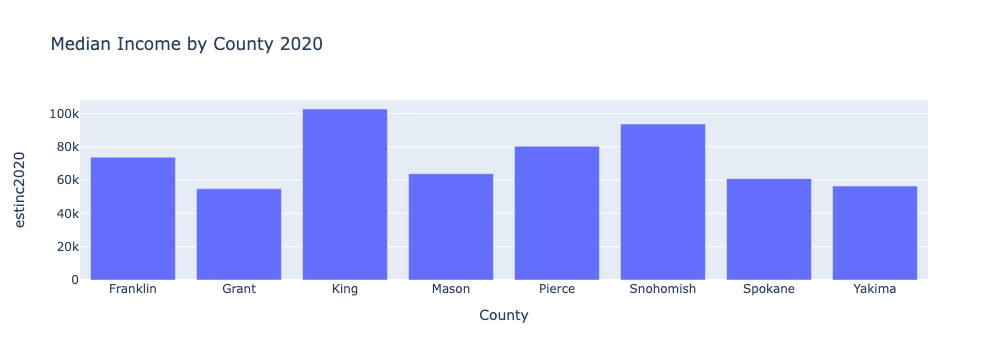

In [797]:
fig = px.bar(income, x="County", y="estinc2020", title="Median Income by County 2020")
fig.show()

In [1051]:
newdata[['lat','lon']]

,lat,lon
13,47.311206,-122.917983
24,48.990550,-122.734947
25,48.990550,-122.734947
40,46.728128,-119.044797
41,46.728128,-119.044797
...,...,...
4000,47.183506,-122.016372
4018,46.342742,-120.173478
4020,46.342742,-120.173478
4022,46.342742,-120.173478


In [1220]:
data['crashcity'].value_counts()

Seattle        316
Tacoma         197
Spokane        191
Vancouver      123
Kent           111
              ... 
Fairfield        1
Toutle           1
South Bend       1
Amanda Park      1
Glenwood         1
Name: crashcity, Length: 304, dtype: int64

In [1223]:
trac = newdata.loc[newdata['d_cty']=='visitor']

trac['crashcity'].value_counts()

Seattle        26
Tacoma         16
Everett        14
Puyallup       13
Kent           12
               ..
Marblemount     1
Ravensdale      1
Tonasket        1
Ephrata         1
Greenacres      1
Name: crashcity, Length: 123, dtype: int64

In [1130]:
data.groupby('d_cty')['crashcity'].value_counts()

d_cty     crashcity 
resident  Spokane       132
          Seattle        66
          Tacoma         46
          Kent           38
          Everett        28
                       ... 
visitor   Valley          1
          Vashon          1
          Waitsburg       1
          Waterville      1
          Wauconda        1
Name: crashcity, Length: 536, dtype: int64

## Observations


- 0.02 (17) of zip codes make up 13.5% of the fatal crashes... why?
- MEDIAN INCOME + ECONOMIC factors should be very important here because people need to have enough $$ to own vehicles in order to get into an accident in the first place right?

In [1029]:
data['age'].describe()

count    4031.000000
mean       43.337881
std        23.594138
min        14.000000
25%        27.000000
50%        41.000000
75%        57.000000
max       999.000000
Name: age, dtype: float64

In [1028]:
newdata['age'].describe()

count    548.000000
mean      41.912409
std       17.539081
min       15.000000
25%       27.750000
50%       38.000000
75%       55.000000
max       89.000000
Name: age, dtype: float64